In [1]:
import sys
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# 현재 노트북 파일의 경로를 기준으로 프로젝트 루트 경로를 계산
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))

# sys.path에 프로젝트 루트 경로가 없으면 추가
if project_root not in sys.path:
  sys.path.append(project_root)


In [2]:
from src.data.db_handler import DBHandler

db_handler = DBHandler(db_name="data_warehouse")

df_income_statement = db_handler.fetch_data(table_name="kr_stock_income_statement")
df_balance_sheet = db_handler.fetch_data(table_name="kr_stock_balance_sheet")
df_financial_ratio = db_handler.fetch_data(table_name="kr_stock_financial_ratio")
df_stability_ratio = db_handler.fetch_data(table_name="kr_stock_stability_ratio")
df_growth_ratio = db_handler.fetch_data(table_name="kr_stock_growth_ratio")
df_profit_ratio = db_handler.fetch_data(table_name="kr_stock_profit_ratio")
df_other_major_ratio = db_handler.fetch_data(table_name="kr_stock_other_major_ratio")


In [3]:
# 테이블 우선순위
priority_order = [
  'df_income_statement',
  'df_balance_sheet',
  'df_financial_ratio',
  'df_stability_ratio',
  'df_growth_ratio',
  'df_profit_ratio',
  'df_other_major_ratio'
]

# 데이터프레임
dataframes = {
  'df_income_statement' : df_income_statement,
  'df_balance_sheet' : df_balance_sheet,
  'df_financial_ratio' : df_financial_ratio,
  'df_stability_ratio' : df_stability_ratio,
  'df_growth_ratio' : df_growth_ratio,
  'df_profit_ratio' : df_profit_ratio,
  'df_other_major_ratio' : df_other_major_ratio
}

key_cols = ['ticker', 'stac_yymm']

# 최종 병합에 사용될, 컬럼이 정리된 데이터프레임들을 저장할 딕셔너리
deduplicated_dataframes = {}
# 이미 선택된 컬럼
seen_columns = set()

# 2. 우선순위 순서대로 순회합니다.
for name in priority_order:
  df = dataframes[name]
  
  # 현재 데이터프레임에서 ticker를 제외하고 아직 보지 못한 새로운 컬럼만 선택
  cols = [col for col in df.columns if (col not in seen_columns) or (col in key_cols)]
  
  # 선택된 컬럼들로 새로운 데이터프레임을 만들어 저장
  deduplicated_dataframes[name] = df[cols]
  #print(f"[{name}]에서 고유 컬럼 {len(cols)}개를 선택했습니다. (중복 제거 : {len(df.columns.to_list())-len(cols)})")
  print(f'Select features in {name:<20} | cols : {len(cols):>2} | drop duplicated cols : {len(df.columns.to_list())-len(cols)}')

  # 'seen_columns' 세트에 방금 추가한 컬럼들을 업데이트
  seen_columns.update(cols)

# 수정된 데이터프레임을 다시 변수에 할당할 수 있습니다.
df_income_statement = deduplicated_dataframes['df_income_statement']
df_balance_sheet = deduplicated_dataframes['df_balance_sheet']
df_financial_ratio = deduplicated_dataframes['df_financial_ratio']
df_stability_ratio = deduplicated_dataframes['df_stability_ratio']
df_growth_ratio = deduplicated_dataframes['df_growth_ratio']
df_profit_ratio = deduplicated_dataframes['df_profit_ratio']
df_other_major_ratio = deduplicated_dataframes['df_other_major_ratio']

Select features in df_income_statement  | cols :  8 | drop duplicated cols : 0
Select features in df_balance_sheet     | cols :  9 | drop duplicated cols : 0
Select features in df_financial_ratio   | cols : 11 | drop duplicated cols : 0
Select features in df_stability_ratio   | cols :  5 | drop duplicated cols : 1
Select features in df_growth_ratio      | cols :  4 | drop duplicated cols : 2
Select features in df_profit_ratio      | cols :  6 | drop duplicated cols : 0
Select features in df_other_major_ratio | cols :  6 | drop duplicated cols : 0


In [4]:
df = df_income_statement.copy()
table = 'df_income_statement'
print(f'kr_stock_quartely_data : merged {table:<20} | rows: {df.shape[0]}, cols: {df.shape[1]}')

for table in priority_order[1:]:
  df = pd.merge(
    df,
    deduplicated_dataframes[table],
    on=['ticker', 'stac_yymm'],
    how='left'
  )
  print(f'kr_stock_quartely_data : merged {table:<20} | rows: {df.shape[0]}, cols: {df.shape[1]}')


kr_stock_quartely_data : merged df_income_statement  | rows: 5759, cols: 8
kr_stock_quartely_data : merged df_balance_sheet     | rows: 5759, cols: 15
kr_stock_quartely_data : merged df_financial_ratio   | rows: 5759, cols: 24
kr_stock_quartely_data : merged df_stability_ratio   | rows: 5759, cols: 27
kr_stock_quartely_data : merged df_growth_ratio      | rows: 5759, cols: 29
kr_stock_quartely_data : merged df_profit_ratio      | rows: 5759, cols: 33
kr_stock_quartely_data : merged df_other_major_ratio | rows: 5759, cols: 37


In [5]:
ROW, COL = df.shape[0], df.shape[1]

df_cols = df.columns.to_list()
columns_info = pd.DataFrame(columns=df_cols)

df.head()

,ticker,stac_yymm,sale_account,sale_cost,sale_totl_prfi,bsop_prti,op_prfi,thtr_ntin,cras,fxas,total_aset,flow_lblt,fix_lblt,total_lblt,total_cptl,grs,bsop_prfi_inrt,ntin_inrt,roe_val,eps,sps,bps,rsrv_rate,lblt_rate,bram_depn,crnt_rate,quck_rate,equt_inrt,totl_aset_inrt,cptl_ntin_rate,self_cptl_ntin_inrt,sale_ntin_rate,sale_totl_rate,payout_rate,eva,ebitda,ev_ebitda
0,005930,2025-06-01,1537068,1000795,536273.0,113613,149077,133393,2121607,2927145,5048752,844026,209106,1053132,3995620,5.29,-33.36,-19.62,6.64,1920.00,45533,58114.00,43513.36,26.36,2.78,251.37,190.90,4.18,3.94,5.23,6.64,8.68,34.89,0.01,0.0,342368.0,0.00
1,005930,2025-03-01,791405,510099,281306.0,66853,91516,82229,2226857,2936910,5163767,902797,194828,1097625,4066143,10.05,1.20,21.74,8.16,1186.00,46778,59027.00,44197.88,26.99,2.16,246.66,187.71,9.33,9.66,6.38,8.16,10.39,35.55,0.02,0.0,182041.0,0.00
2,005930,2024-12-01,3008709,1865623,1143086.0,327260,375297,344514,2270623,2874697,5145319,933263,190136,1123399,4021921,16.20,398.34,122.45,9.03,4950.00,44293,57930.00,43743.26,27.93,3.76,243.30,187.84,10.59,12.86,7.10,9.03,11.45,37.99,0.00,29209.0,753568.0,4.84
3,005930,2024-09-01,2250826,1392934,857892.0,262333,296225,266970,2192351,2720722,4913073,870319,179941,1050260,3862814,17.75,601.00,192.01,9.52,3834.00,44181,55376.00,41810.45,27.19,3.45,251.90,190.59,6.15,8.11,7.52,9.52,11.86,38.11,0.01,0.0,573635.0,0.00
4,005930,2024-06-01,1459839,901984,557855.0,170499,193021,165961,2178581,2678996,4857577,843549,178761,1022310,3835267,17.97,1202.79,403.19,8.95,2394.00,42983,55011.00,41533.84,26.66,3.39,258.26,192.39,6.84,8.43,7.05,8.95,11.37,38.21,0.01,0.0,371226.0,0.00


In [6]:
df[df_cols] = df[df_cols].replace(r'^\s*$', np.nan, regex=True)
df[df_cols] = df[df_cols].replace(['0', 0], np.nan)

In [7]:
# 결측값 개수/비율 산출 및 제거 리스트
missing_count = df[df_cols].isnull().sum()
missing_percent = ((missing_count / ROW) * 100).round(2)

missing_df = pd.DataFrame({
  'missing_count': missing_count,
  'missing_percent': missing_percent
})

columns_info.loc['missing_count'] = missing_df['missing_count']
columns_info.loc['missing_percent'] = missing_df['missing_percent']

In [8]:
# 중복값 개수/비율 산출 및 제거 리스트 설정
unique_count = df[df_cols].nunique()
unique_percent = ((unique_count / ROW) * 100).round(2)

unique_df = pd.DataFrame({
  'unique_count': unique_count,
  'unique_percent': unique_percent
})

columns_info.loc['unique_count'] = unique_df['unique_count']
columns_info.loc['unique_percent'] = unique_df['unique_percent']

In [9]:
# 컬럼 정보
columns_info

,ticker,stac_yymm,sale_account,sale_cost,sale_totl_prfi,bsop_prti,op_prfi,thtr_ntin,cras,fxas,total_aset,flow_lblt,fix_lblt,total_lblt,total_cptl,grs,bsop_prfi_inrt,ntin_inrt,roe_val,eps,sps,bps,rsrv_rate,lblt_rate,bram_depn,crnt_rate,quck_rate,equt_inrt,totl_aset_inrt,cptl_ntin_rate,self_cptl_ntin_inrt,sale_ntin_rate,sale_totl_rate,payout_rate,eva,ebitda,ev_ebitda
missing_count,0.00,0.00,4.00,386.0,4.00,0.00,4.00,4.00,668.00,668.00,63.00,668.00,674.00,63.00,63.00,132.00,914.00,1258.00,111.00,0.00,6.00,0.00,134.00,71.00,134.00,668.0,668.00,214.00,197.00,107.00,111.00,5.00,4.00,824.00,4525.00,2.00,4609.00
missing_percent,0.00,0.00,0.07,6.7,0.07,0.00,0.07,0.07,11.60,11.60,1.09,11.60,11.70,1.09,1.09,2.29,15.87,21.84,1.93,0.00,0.10,0.00,2.33,1.23,2.33,11.6,11.60,3.72,3.42,1.86,1.93,0.09,0.07,14.31,78.57,0.03,80.03
unique_count,200.00,37.00,5522.00,5097.0,4910.00,4151.00,4263.00,3981.00,4906.00,4932.00,5609.00,4818.00,4573.00,5490.00,5519.00,3808.00,4246.00,4083.00,2862.00,4470.00,5692.00,5594.00,5609.00,5202.00,3465.00,4561.0,4490.00,3100.00,3062.00,1952.00,2862.00,2504.00,3433.00,1310.00,1124.00,4490.00,875.00
unique_percent,3.47,0.64,95.88,88.5,85.26,72.08,74.02,69.13,85.19,85.64,97.40,83.66,79.41,95.33,95.83,66.12,73.73,70.90,49.70,77.62,98.84,97.13,97.40,90.33,60.17,79.2,77.96,53.83,53.17,33.89,49.70,43.48,59.61,22.75,19.52,77.96,15.19


In [10]:
MISSING_PERCENT_THRESHOLD = 50.0
UNIQUE_COUNT_THRESHOLD = 1

# --- 2. Identify Columns to Drop ---
missing_info = columns_info.loc['missing_percent']
unique_info = columns_info.loc['unique_count']

# 제거할 컬럼과 그 이유(값)를 함께 저장
drop_missing_cols = {
  col: val for col, val in missing_info.items() 
  if val > MISSING_PERCENT_THRESHOLD
}
drop_unique_cols = {
  col: val for col, val in unique_info.items() 
  if val <= UNIQUE_COUNT_THRESHOLD
}

# 최종 제거 목록 생성
total_drop_cols = sorted(list(set(drop_missing_cols.keys()) | set(drop_unique_cols.keys())))

# --- 3. Logging and Execution ---
print("="*80)
print("Step: Feature Selection based on Data Quality".center(80))
print("="*80)

# [INFO] Initial DataFrame shape: 출력
left_str = "[INFO] Initial DataFrame shape:"
right_str = str(df.shape)
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

# [INFO] Thresholds: 출력 (사용자 요청 최종 포맷 적용)
left_str = "[INFO] Thresholds"
# --- Missing % 라인 ---
right_str = f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%"
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

# --- Unique Count 라인 ---
right_str = f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}"
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

print("-"*80)


if total_drop_cols:
  df_cleaned = df.drop(columns=total_drop_cols)
  
  print("[ACTION] Dropping columns...")
  
  if drop_missing_cols:
    header_text = f" Reason: High Missing Value Ratio ({len(drop_missing_cols)} columns) "
    print(f"\n{header_text.center(80, '-')}")
    for col, val in drop_missing_cols.items():
      left_str = f"- Dropping {col}"
      right_str = f"(Missing: {val:.2f}%)"
      padding = 80 - len(right_str)
      print(f"{left_str:<{padding}}{right_str}")
          
  if drop_unique_cols:
    header_text = f" Reason: Low Unique Value Count ({len(drop_unique_cols)} columns) "
    print(f"\n{header_text.center(80, '-')}")
    for col, val in drop_unique_cols.items():
      left_str = f"- Dropping {col}"
      right_str = f"(Unique Count: {int(val)})"
      padding = 80 - len(right_str)
      print(f"{left_str:<{padding}}{right_str}")

  print("\n" + "-"*80)
  print(f"[SUMMARY] Total {len(total_drop_cols)} columns dropped.")
  print(f"[SUMMARY] Cleaned DataFrame shape: {df_cleaned.shape}")

else:
  df_cleaned = df.copy()
  print("[SUMMARY] No columns to drop. DataFrame remains unchanged.")

print("="*80)


                 Step: Feature Selection based on Data Quality                  
[INFO] Initial DataFrame shape:                                       (5759, 37)
[INFO] Thresholds                                        Missing Percent > 50.0%
[INFO] Thresholds                                           Unique Count <=    1
--------------------------------------------------------------------------------
[ACTION] Dropping columns...

----------------- Reason: High Missing Value Ratio (2 columns) -----------------
- Dropping eva                                                 (Missing: 78.57%)
- Dropping ev_ebitda                                           (Missing: 80.03%)

--------------------------------------------------------------------------------
[SUMMARY] Total 2 columns dropped.
[SUMMARY] Cleaned DataFrame shape: (5759, 35)


In [11]:
import pandas as pd
import numpy as np

# 1. 수치형 컬럼 선택
cleaned_numeric_cols = df_cleaned.select_dtypes(include=np.number).columns.tolist()

# 2. 범주형 컬럼 선택
cleaned_categorical_cols = df_cleaned.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

# 3. Datetime 컬럼 선택 (누락되었던 부분)
cleaned_datetime_cols = df_cleaned.select_dtypes(include=['datetime64[ns]']).columns.tolist()

if 'ticker' in cleaned_categorical_cols:
  cleaned_categorical_cols.remove('ticker')
if 'stac_yymm' in cleaned_categorical_cols:
  cleaned_categorical_cols.remove('stac_yymm')

# --- 결과 확인 ---
print(f"총 {len(df_cleaned.columns)}개의 컬럼이 3개의 그룹으로 분리되었습니다.")
print("-" * 50)
print(f"수치형 컬럼 ({len(cleaned_numeric_cols)}개)")
print(f"범주형 컬럼 ({len(cleaned_categorical_cols)}개)")
print(f"Datetime 컬럼 ({len(cleaned_datetime_cols)}개)")
print("-" * 50)

# 최종 검증
total_classified = len(cleaned_numeric_cols) + len(cleaned_categorical_cols) + len(cleaned_datetime_cols)
print(f"검증: {total_classified + 1} (분류된 컬럼) == {len(df_cleaned.columns)} (전체 컬럼)")

총 35개의 컬럼이 3개의 그룹으로 분리되었습니다.
--------------------------------------------------
수치형 컬럼 (30개)
범주형 컬럼 (3개)
Datetime 컬럼 (1개)
--------------------------------------------------
검증: 35 (분류된 컬럼) == 35 (전체 컬럼)


✅ 총 8개의 변수 쌍에서 임계값(0.95)을 초과하는 높은 상관관계가 발견되었습니다.
👉 상관관계가 높은 변수 개수: 13개
👉 상관관계가 낮은 변수 개수: 17개


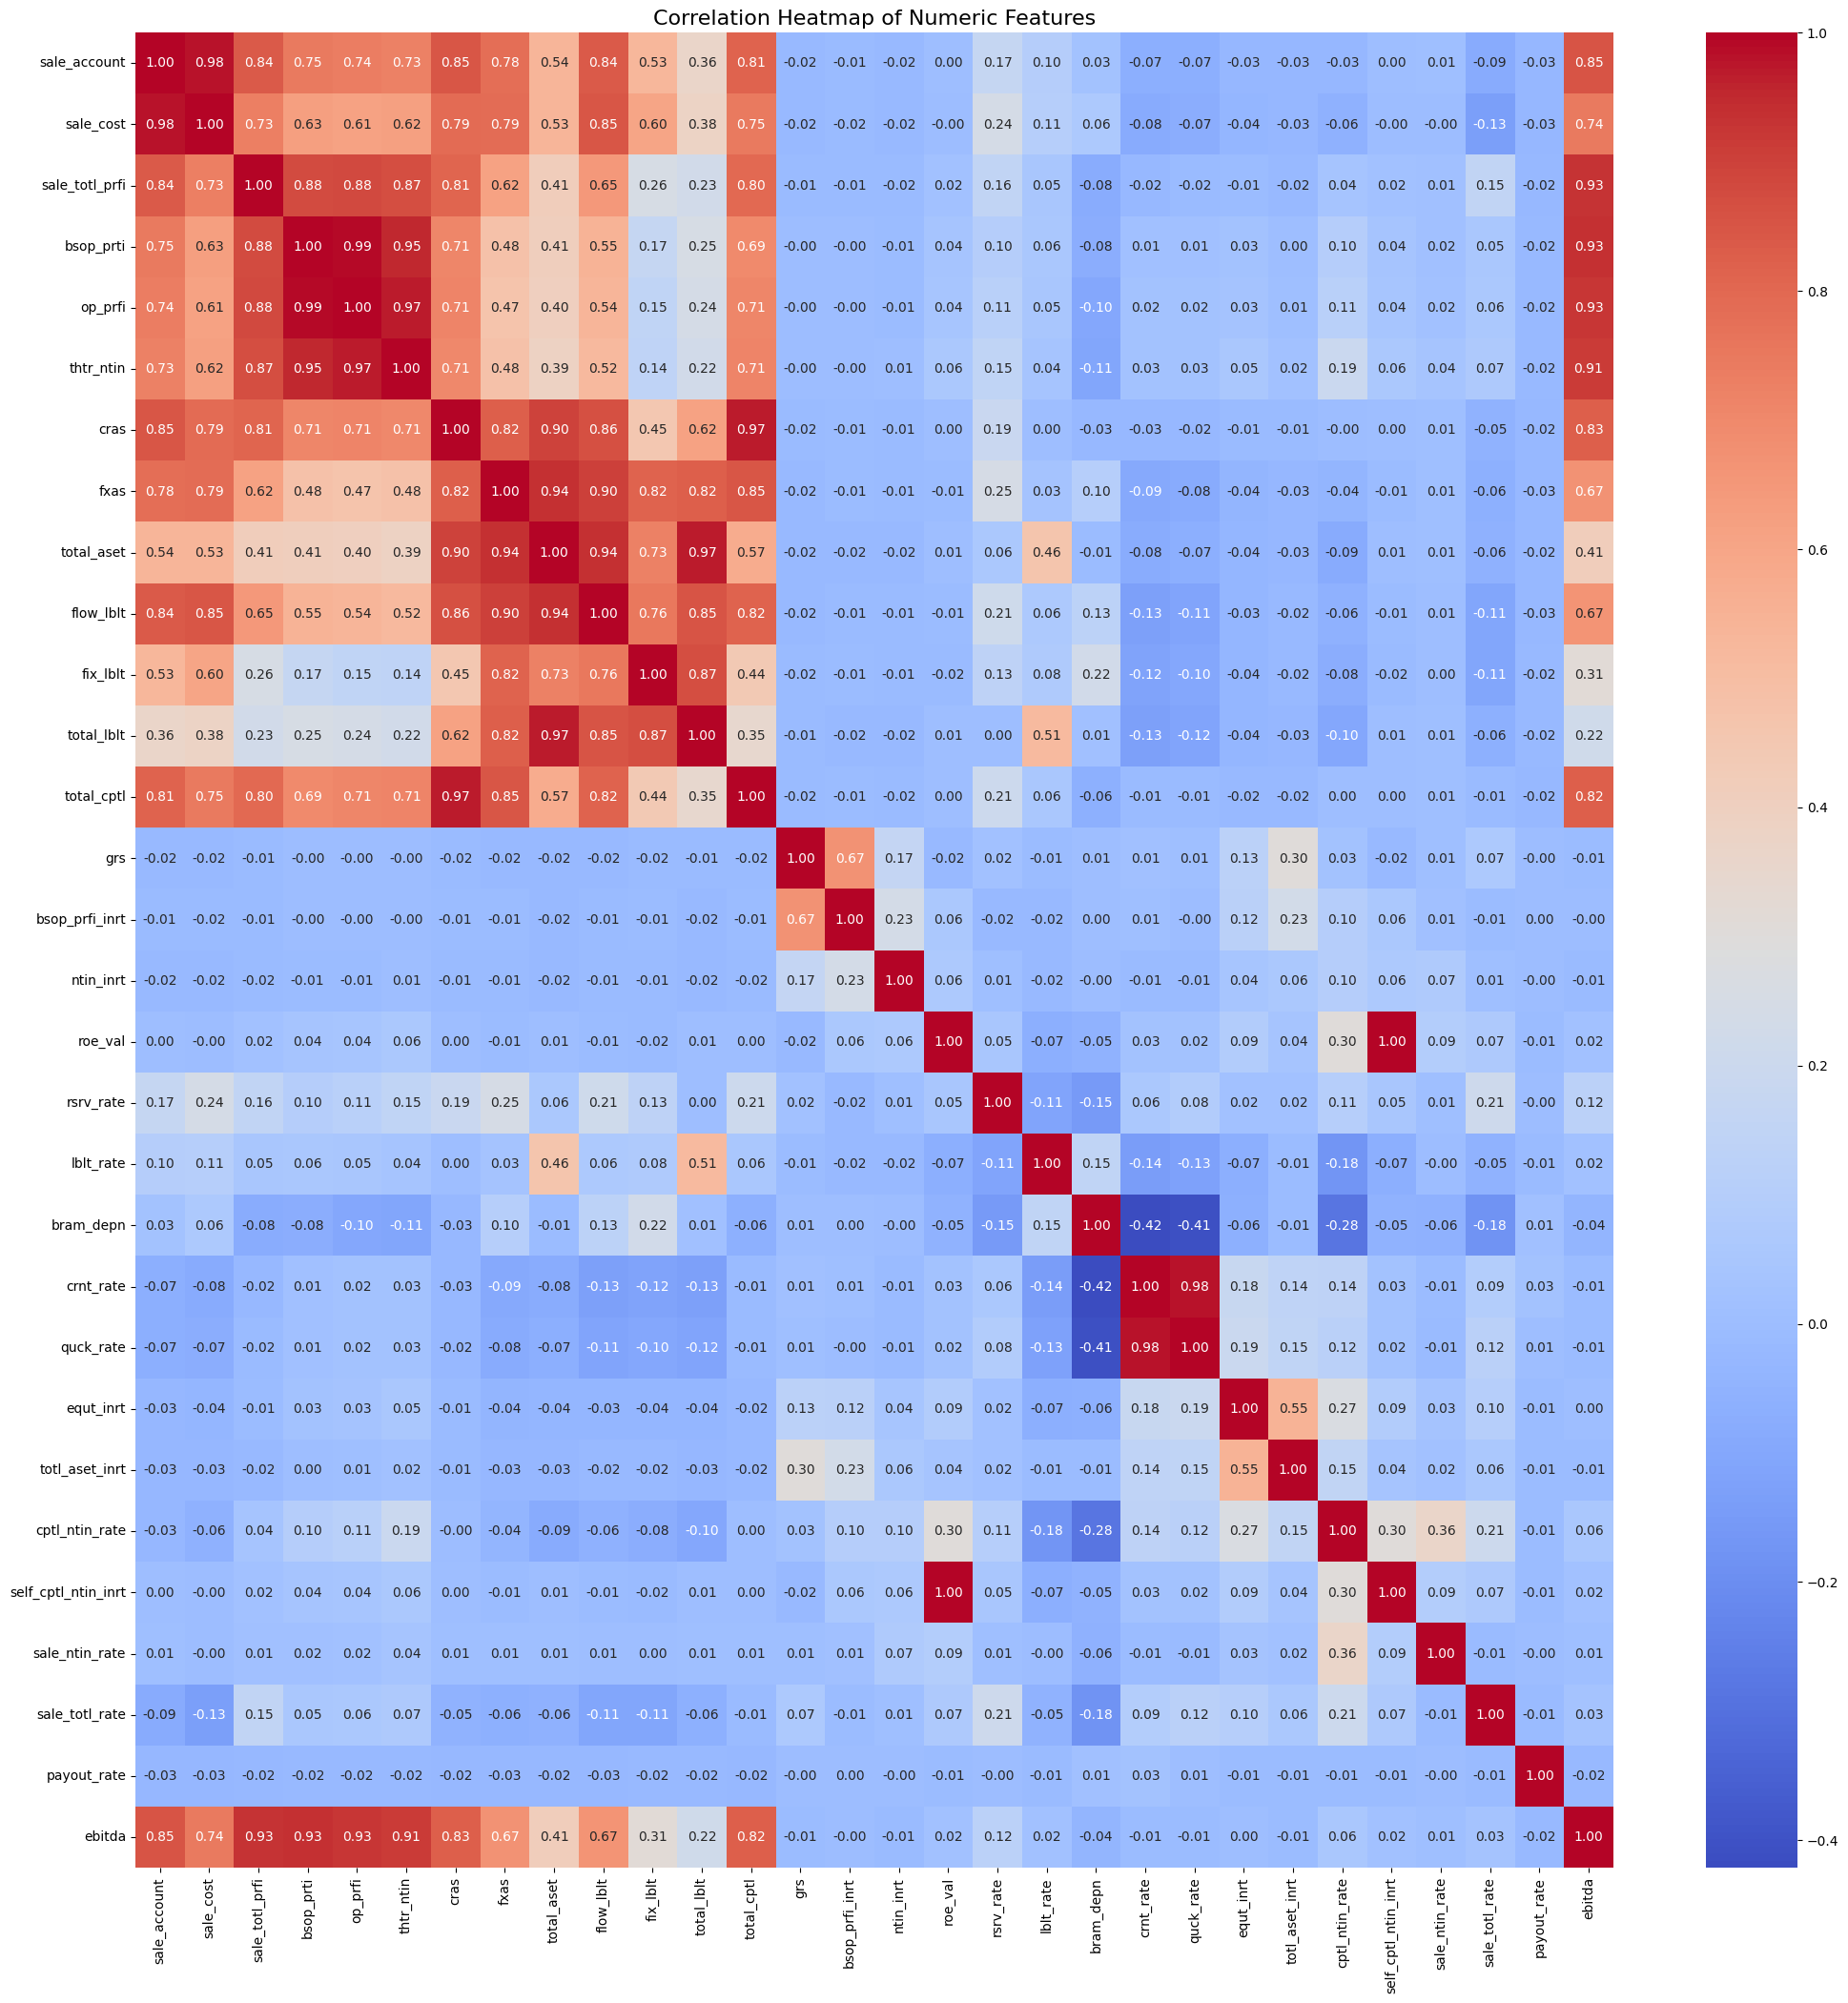

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: 상관관계 행렬 계산 ---
numeric_df = df_cleaned[cleaned_numeric_cols]
corr_matrix = numeric_df.corr(method='pearson')

# --- Step 2: 높은 상관관계를 가진 변수 쌍 자동 추출 ---
THRESHHOLD = 0.95
num_high_corr_pairs = []

# 중복을 피하기 위해 상관 행렬의 상삼각행렬(upper triangle)만 순회
for i in range(len(corr_matrix.columns)):
  for j in range(i):
    if abs(corr_matrix.iloc[i, j]) > THRESHHOLD:
      pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
      num_high_corr_pairs.append(pair)

# 상관계수가 높은 순으로 정렬
num_high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"✅ 총 {len(num_high_corr_pairs)}개의 변수 쌍에서 임계값({THRESHHOLD})을 초과하는 높은 상관관계가 발견되었습니다.")

# --- Step 3: 상관관계가 높은 변수와 낮은 변수 리스트 분리 ---

# 상관관계가 높은 변수들의 이름만 추출 (중복 제거를 위해 set 사용)
# num_high_corr_pairs 리스트를 순회하며 각 튜플의 첫 번째, 두 번째 원소(변수 이름)를 모두 가져옵니다.
high_corr_cols_set = set()
for pair in num_high_corr_pairs:
  high_corr_cols_set.add(pair[0])
  high_corr_cols_set.add(pair[1])

high_corr_cols = list(high_corr_cols_set) # 최종 리스트로 변환

# 전체 숫자형 변수 중, high_corr_cols에 포함되지 않은 변수들만 선택
# 이 변수들은 다른 변수와 상관관계가 높지 않아 그대로 사용해도 좋은 후보들입니다.
low_corr_cols = [col for col in cleaned_numeric_cols if col not in high_corr_cols]

# [결과 확인]
print(f"👉 상관관계가 높은 변수 개수: {len(high_corr_cols)}개")
print(f"👉 상관관계가 낮은 변수 개수: {len(low_corr_cols)}개")


# --- Step 4: 히트맵 시각화 (전체적인 분포 확인용) ---
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.show()

✅ 총 6개의 상관관계 그룹을 자동으로 찾았습니다.
--------------------------------------------------


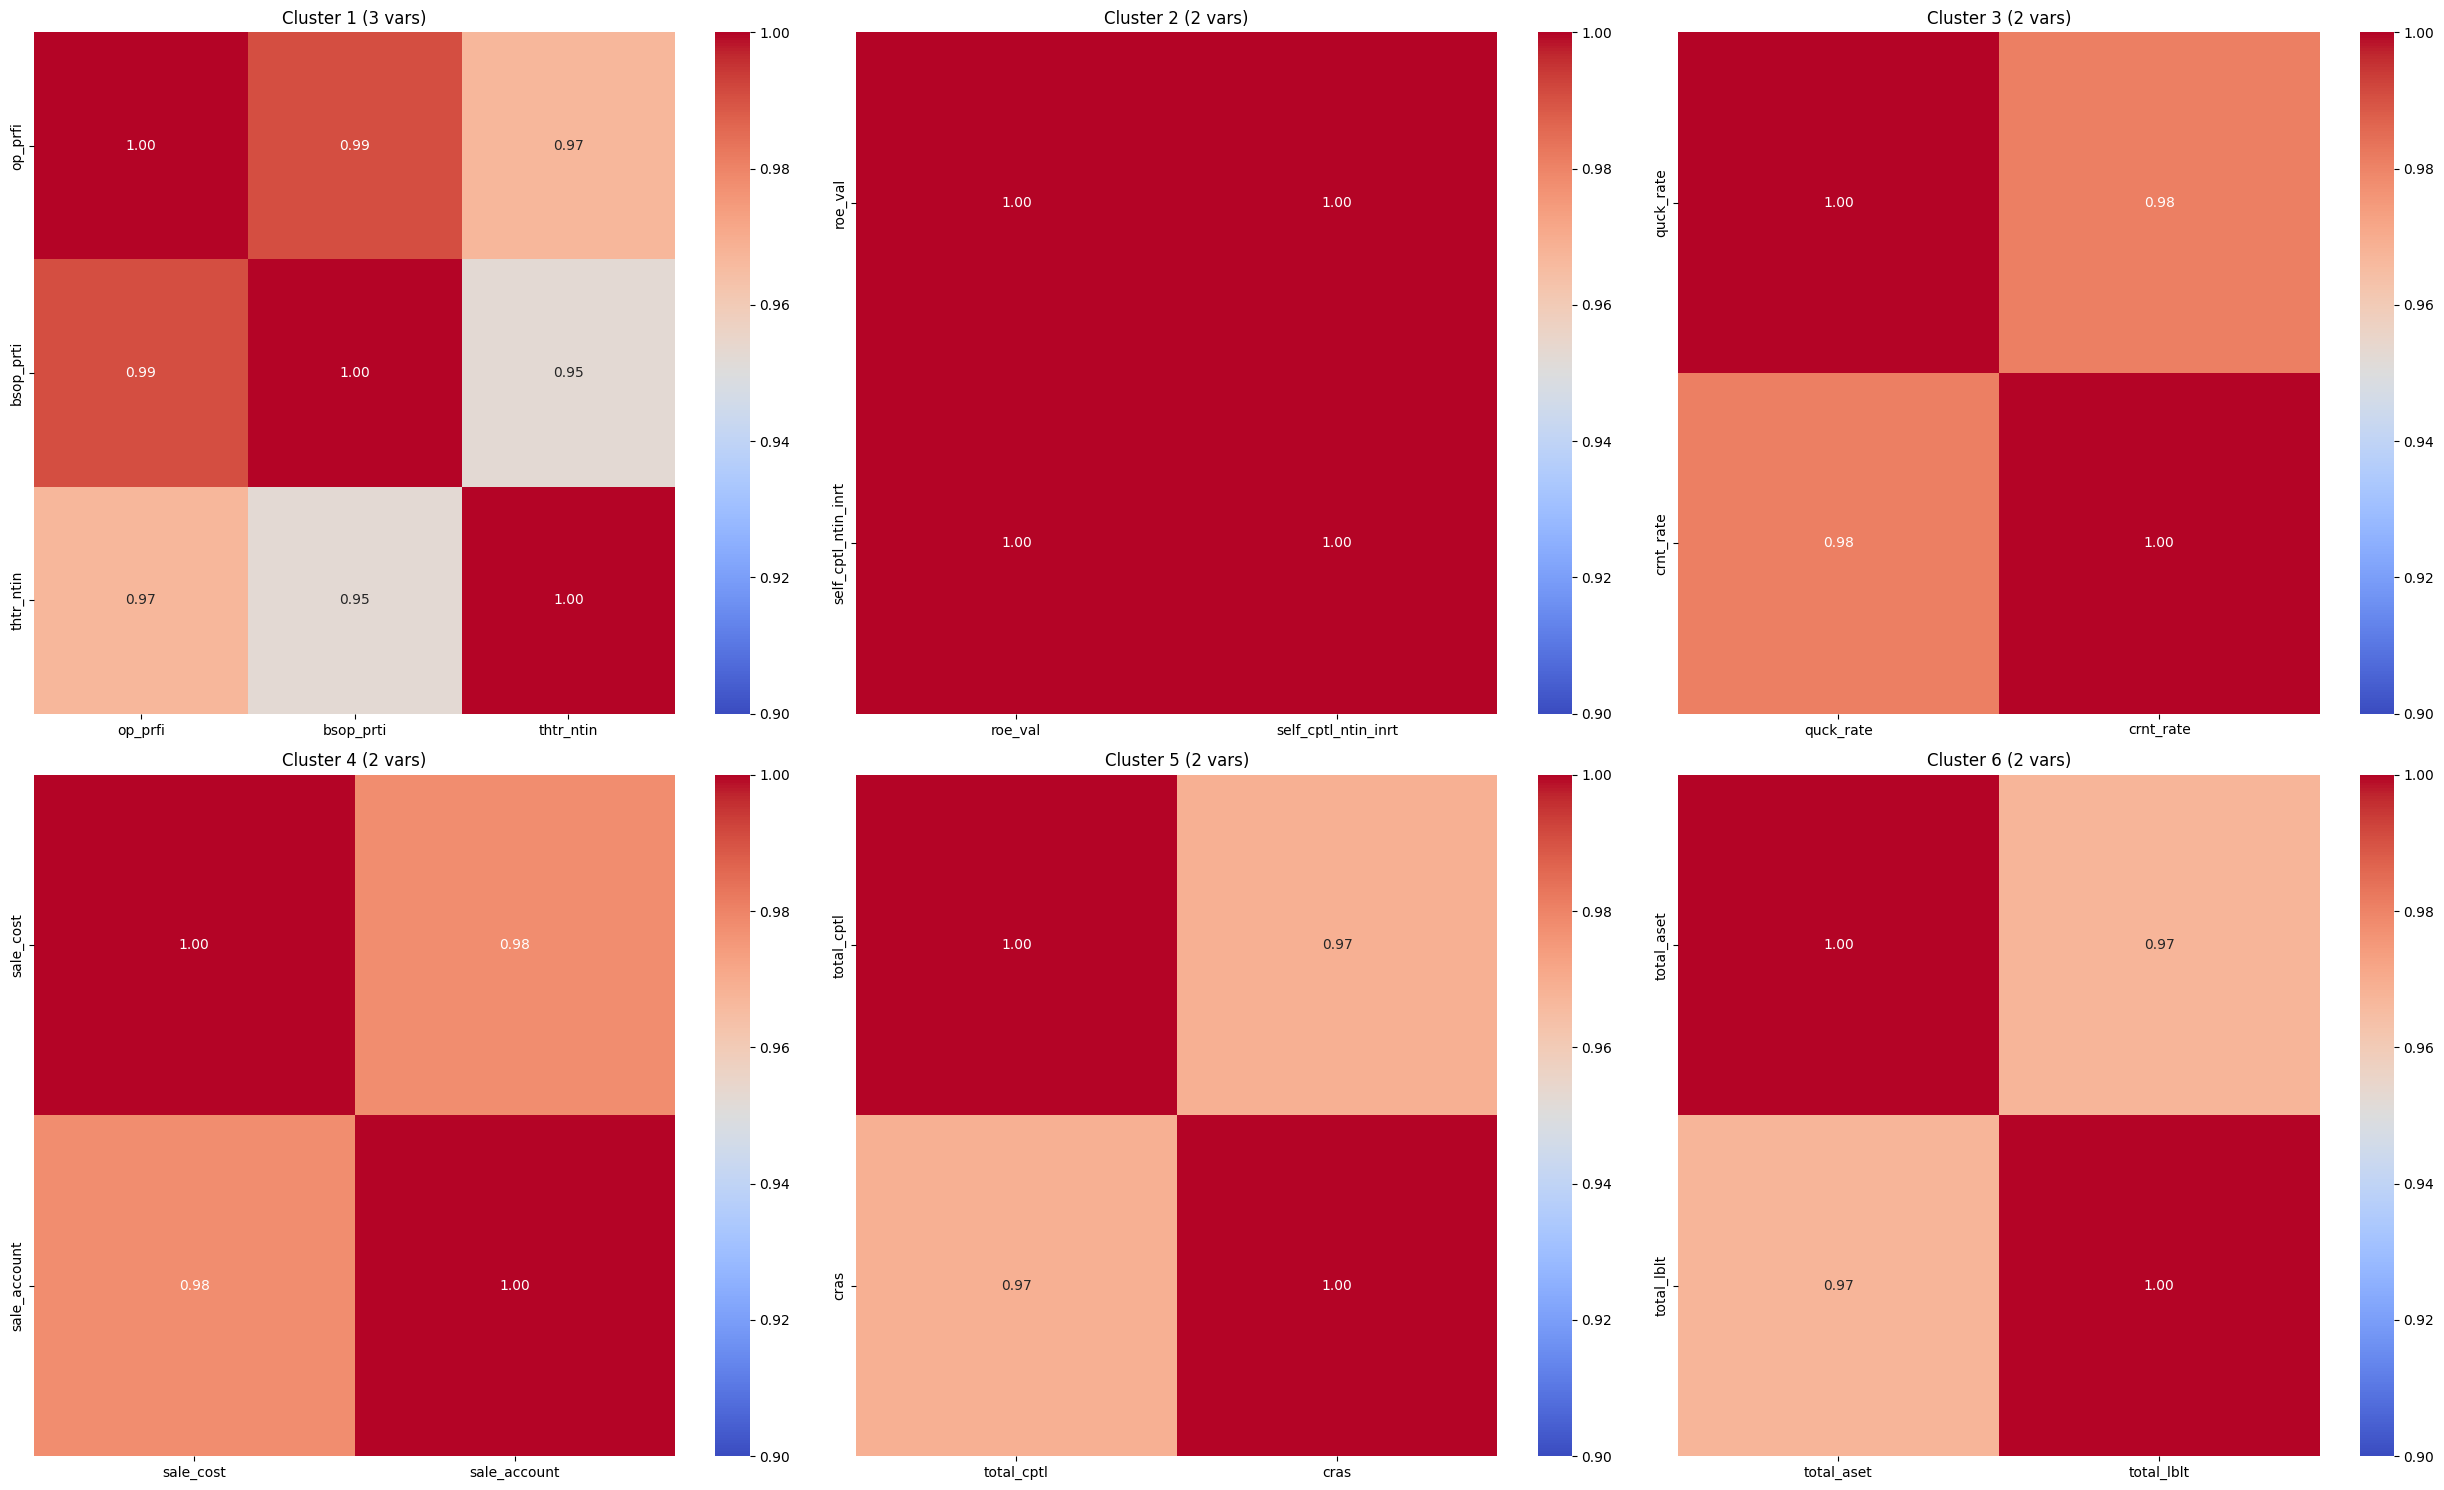

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# --- 기존 그룹핑 코드 ---
G = nx.Graph()
edges = [(pair[0], pair[1]) for pair in num_high_corr_pairs]
G.add_edges_from(edges)
clusters = list(nx.connected_components(G))

print(f"✅ 총 {len(clusters)}개의 상관관계 그룹을 자동으로 찾았습니다.")
print("-" * 50)

# 1. 3x3 그리드(subplot)를 생성합니다. 전체 이미지 크기를 크게 설정합니다.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))

# 2. axes 배열을 1차원으로 펼쳐서 다루기 쉽게 만듭니다.
ax_flat = axes.flatten()

# 3. 클러스터를 크기 순으로 정렬합니다.
sorted_clusters = sorted(clusters, key=len, reverse=True)

# 4. 각 클러스터에 대해 루프를 실행하며 순서대로 subplot에 히트맵을 그립니다.
for i, cluster_vars in enumerate(sorted_clusters):
  ax = ax_flat[i] # 현재 그릴 subplot 위치 선택
  
  if len(cluster_vars) > 1:
    cluster_df = numeric_df[list(cluster_vars)]
    cluster_corr_matrix = cluster_df.corr()
    
    # cmap='coolwarm'으로 색상 변경, ax=ax로 위치 지정
    sns.heatmap(cluster_corr_matrix, cmap='coolwarm', ax=ax, vmin=0.9, vmax=1.0, annot=True, fmt='.2f')
    ax.set_title(f'Cluster {i+1} ({len(cluster_vars)} vars)')
  else:
    # 변수가 하나뿐인 클러스터는 비워둡니다.
    ax.axis('off')

# 5. 만약 클러스터 개수가 12개보다 적을 경우, 남는 subplot 공간을 숨깁니다.
for i in range(len(sorted_clusters), len(ax_flat)):
  ax_flat[i].axis('off')

# 6. 그래프들이 겹치지 않도록 레이아웃을 자동 조정합니다.
plt.tight_layout()
plt.show()

In [14]:
print("\n\n" + "="*80)
print("각 그룹별 평균 상관계수 분석 (대표 변수 선정을 위한 최종 분석)")
print("="*80)

# --- 각 그룹별 평균 상관계수 계산 및 출력 로직 ---
for i, cluster_vars in enumerate(sorted_clusters):
  cluster_num = i + 1
  
  if len(cluster_vars) > 1:
    # 1. 전체 상관관계 행렬에서 현재 클러스터에 해당하는 부분만 선택
    cluster_corr = corr_matrix.loc[list(cluster_vars), list(cluster_vars)]
    
    # 2. 각 변수별로 다른 변수들과의 평균 상관계수(절댓값 기준)를 계산
    #    .abs()를 통해 양/음의 방향성 없이 관계의 강도만으로 계산
    avg_corr = cluster_corr.abs().mean().sort_values(ascending=False)
    
    # 3. 결과 출력
    header_text = f" Cluster {cluster_num} ({len(cluster_vars)} vars) Average Correlation "
    print(f"\n{header_text.center(80, '-')}")
    print(avg_corr)



각 그룹별 평균 상관계수 분석 (대표 변수 선정을 위한 최종 분석)

-------------------- Cluster 1 (3 vars) Average Correlation --------------------
op_prfi      0.985901
bsop_prti    0.981198
thtr_ntin    0.973168
dtype: float64

-------------------- Cluster 2 (2 vars) Average Correlation --------------------
roe_val                1.0
self_cptl_ntin_inrt    1.0
dtype: float64

-------------------- Cluster 3 (2 vars) Average Correlation --------------------
quck_rate    0.990441
crnt_rate    0.990441
dtype: float64

-------------------- Cluster 4 (2 vars) Average Correlation --------------------
sale_cost       0.989
sale_account    0.989
dtype: float64

-------------------- Cluster 5 (2 vars) Average Correlation --------------------
total_cptl    0.98446
cras          0.98446
dtype: float64

-------------------- Cluster 6 (2 vars) Average Correlation --------------------
total_aset    0.98369
total_lblt    0.98369
dtype: float64


### 그룹 1: 이익(Profit) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `op_prfi` | 영업외손익 | **선정** | 영업 외 활동의 성과를 나타내는 고유한 이익 지표. |
| `bsop_prti` | 영업이익 | **선정** | 기업의 핵심적인 영업 활동 성과를 나타내는 가장 중요한 이익 지표. |
| `thtr_ntin` | 당기순이익 | **선정** | 모든 비용과 수익을 반영한 최종적인 이익 지표. |

---
### 그룹 2: 자기자본수익성(Return on Equity) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `roe_val` | 자기자본이익률 (ROE) | **선정** | 가장 표준적으로 사용되는 자기자본수익률 지표. |
| `self_cptl_ntin_inrt`| 자기자본순이익률 | 제거 | `roe_val`과 완전히 동일한 의미의 중복 변수. (대체 가능: `roe_val`) |

---
### 그룹 3: 유동성(Liquidity) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `quck_rate` | 당좌비율 | **선정** | 재고자산을 제외한 단기 지급 능력을 나타내는 엄격한 유동성 지표. |
| `crnt_rate` | 유동비율 | **선정** | 재고자산을 포함한 일반적인 단기 지급 능력을 나타내는 지표로, 당좌비율과 상호 보완적인 정보를 제공. |

---
### 그룹 4: 매출/원가 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `sale_account`| 매출액 | **선정** | 기업의 최상위 실적을 나타내는 핵심적인 기초 데이터. |
| `sale_cost` | 매출원가 | **선정** | 매출 총이익 계산에 필수적인 핵심 기초 데이터. |

---
### 그룹 5: 자본/유동자산 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `total_cptl`| 자본총계 | **선정** | 재무상태표의 핵심 구성 요소로, 기업의 순자산을 나타냄. |
| `cras` | 유동자산 | **선정** | 재무상태표의 핵심 구성 요소로, 단기 자금 동원 능력을 나타냄. |

---
### 그룹 6: 총자산/총부채 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `total_aset`| 자산총계 | **선정** | 기업의 전체적인 규모를 나타내는 대표적인 지표. |
| `total_lblt`| 부채총계 | **선정** | 기업의 총부채 규모를 나타내는 지표로, 자산총계와 함께 안정성 분석에 필수적. |


In [15]:
# 그룹 1: 이익(Profit) 그룹
selected_cluster_1 = ['op_prfi', 'bsop_prti', 'thtr_ntin']
# 그룹 2: 자기자본수익성(Return on Equity) 그룹
selected_cluster_2 = ['roe_val']
# 그룹 3: 유동성(Liquidity) 그룹
selected_cluster_3 = ['quck_rate', 'crnt_rate']
# 그룹 4: 매출/원가 그룹
selected_cluster_4 = ['sale_account', 'sale_cost']
# 그룹 5: 자본/유동자산 그룹
selected_cluster_5 = ['total_cptl', 'cras']
# 그룹 6: 총자산/총부채 그룹
selected_cluster_6 = ['total_aset', 'total_lblt']

# 모든 리스트를 하나로 통합
selected_numeric_cols = (
  low_corr_cols +
  selected_cluster_1 +
  selected_cluster_2 +
  selected_cluster_3 +
  selected_cluster_4 +
  selected_cluster_5 +
  selected_cluster_6
)

# --- 최종 결과 확인 ---
print(f"✅ 총 {len(selected_numeric_cols)}개의 수치형 변수가 최종 선정되었습니다.")
print("\n--- 최종 선정된 수치형 변수 목록 ---")
print(selected_numeric_cols)

✅ 총 29개의 수치형 변수가 최종 선정되었습니다.

--- 최종 선정된 수치형 변수 목록 ---
['sale_totl_prfi', 'fxas', 'flow_lblt', 'fix_lblt', 'grs', 'bsop_prfi_inrt', 'ntin_inrt', 'rsrv_rate', 'lblt_rate', 'bram_depn', 'equt_inrt', 'totl_aset_inrt', 'cptl_ntin_rate', 'sale_ntin_rate', 'sale_totl_rate', 'payout_rate', 'ebitda', 'op_prfi', 'bsop_prti', 'thtr_ntin', 'roe_val', 'quck_rate', 'crnt_rate', 'sale_account', 'sale_cost', 'total_cptl', 'cras', 'total_aset', 'total_lblt']


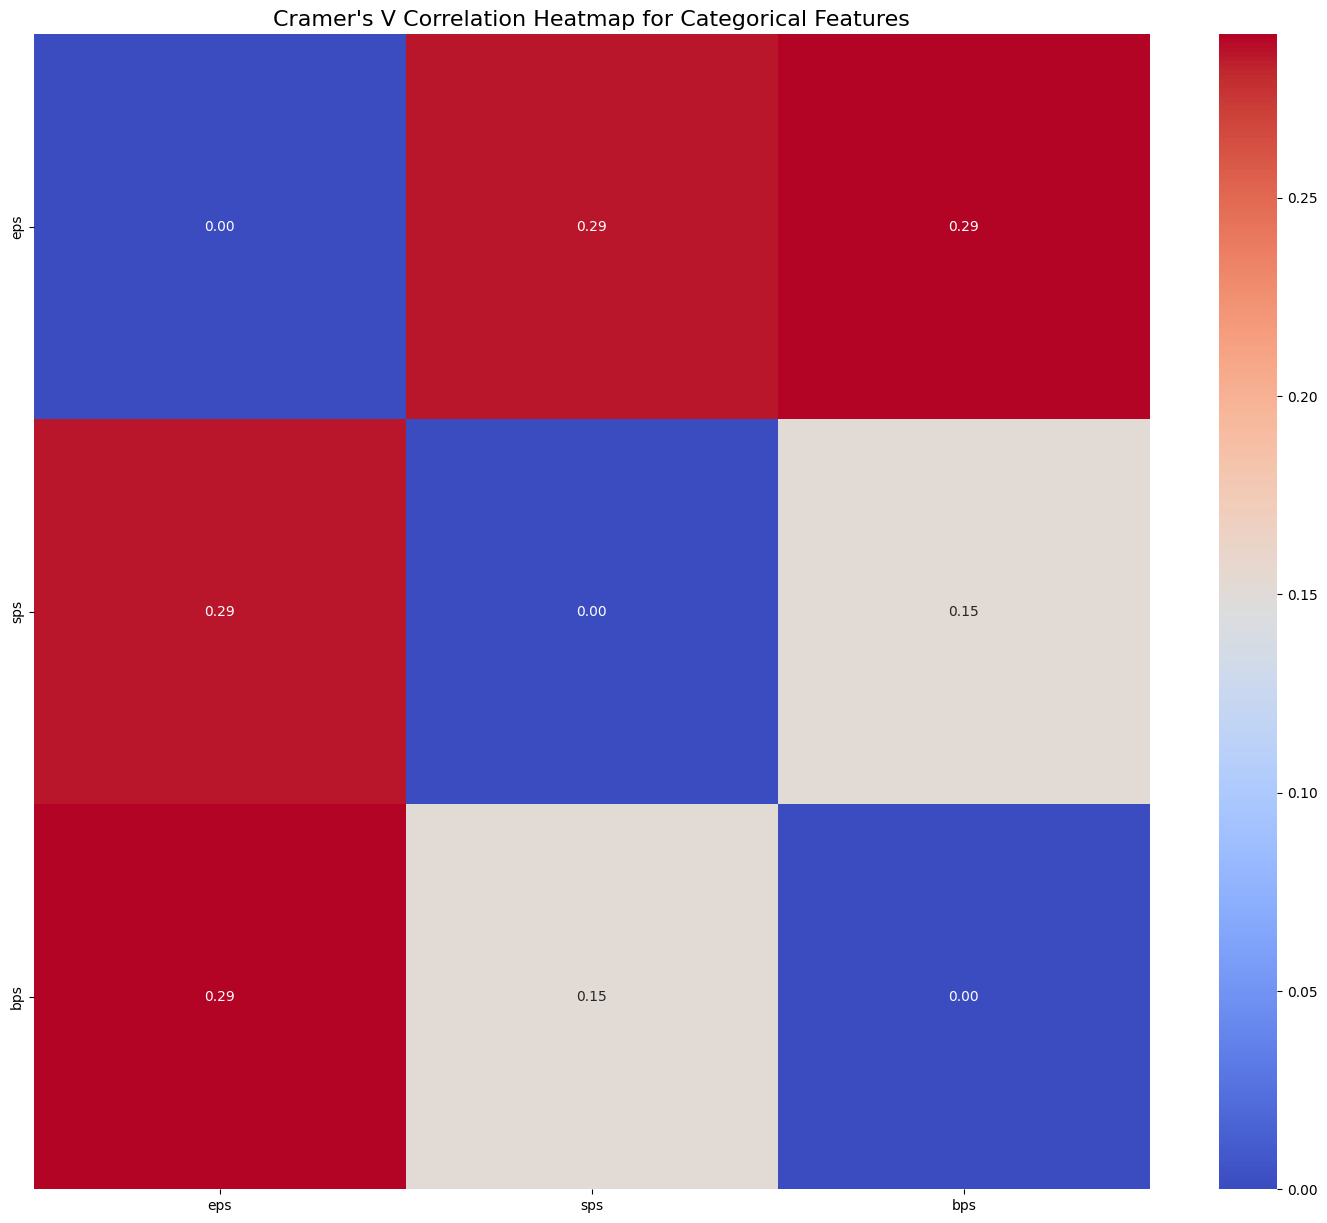


✅ 총 0개의 변수 쌍에서 임계값(0.95)을 초과하는 높은 연관성이 발견되었습니다.
----------------------------------------------------------------------
연관성이 높은 변수 쌍:

👉 연관성이 높은 변수 리스트 (0개):
[]

👉 연관성이 낮은 변수 리스트 (3개):
['eps', 'sps', 'bps']


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import combinations

categorical_df = df_cleaned[cleaned_categorical_cols].astype('str')

# --- Step 1: 크래머 V 계산을 위한 함수 정의 ---
def cramers_v(contingency_table):
  """ 두 범주형 변수 간의 크래머 V 계수를 계산합니다. """
  chi2 = chi2_contingency(contingency_table)[0]
  n = contingency_table.sum().sum()
  phi2 = chi2 / n
  r, k = contingency_table.shape
  phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
  r_corr = r - ((r-1)**2)/(n-1)
  k_corr = k - ((k-1)**2)/(n-1)
  if min((k_corr-1), (r_corr-1)) == 0:
    return 0
  else:
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# --- Step 2: 크래머 V 상관 행렬 계산 ---
cramers_v_matrix = pd.DataFrame(
  np.zeros((len(cleaned_categorical_cols), len(cleaned_categorical_cols))),
  index=cleaned_categorical_cols,
  columns=cleaned_categorical_cols
)

for col1, col2 in combinations(cleaned_categorical_cols, 2):
  contingency = pd.crosstab(categorical_df[col1], categorical_df[col2])
  v = cramers_v(contingency)
  cramers_v_matrix.loc[col1, col2] = v
  cramers_v_matrix.loc[col2, col1] = v

# --- Step 3: 히트맵 시각화 ---
plt.figure(figsize=(18, 15))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cramer\'s V Correlation Heatmap for Categorical Features', fontsize=16)
plt.show()

# --- Step 4: 연관성이 높은 변수 쌍 추출 ---
threshold = 0.95
str_high_corr_pairs = []

for i in range(len(cramers_v_matrix.columns)):
  for j in range(i):
    if cramers_v_matrix.iloc[i, j] > threshold:
      pair = (cramers_v_matrix.columns[i], cramers_v_matrix.columns[j], cramers_v_matrix.iloc[i, j])
      str_high_corr_pairs.append(pair)

str_high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\n✅ 총 {len(str_high_corr_pairs)}개의 변수 쌍에서 임계값({threshold})을 초과하는 높은 연관성이 발견되었습니다.")
print("-" * 70)
print("연관성이 높은 변수 쌍:")
for pair in str_high_corr_pairs:
  print(f"- {pair[0]} & {pair[1]}: {pair[2]:.4f}")

# --- Step 5: 연관성이 높은 변수와 낮은 변수 리스트 분리 ---

# 1. 연관성이 높은 변수들의 이름만 추출 (중복 제거를 위해 set 사용)
high_corr_cols_set = set()
for pair in str_high_corr_pairs:
  high_corr_cols_set.add(pair[0])
  high_corr_cols_set.add(pair[1])

high_corr_cols = list(high_corr_cols_set)

# 2. 전체 범주형 변수 중, high_corr_cols에 포함되지 않은 변수들만 선택
low_corr_cols = [col for col in cleaned_categorical_cols if col not in high_corr_cols]

# 3. 결과 확인
print("\n" + "="*70)
print(f"👉 연관성이 높은 변수 리스트 ({len(high_corr_cols)}개):")
print(high_corr_cols)
print("\n" + "="*70)
print(f"👉 연관성이 낮은 변수 리스트 ({len(low_corr_cols)}개):")
print(low_corr_cols)
print("="*70)

In [17]:
selected_categorical_cols = low_corr_cols

In [18]:
final_cols = selected_numeric_cols + selected_categorical_cols + cleaned_datetime_cols

print(f"final cols({len(final_cols)}) = numerical({len(selected_numeric_cols)}) + categorical({len(selected_categorical_cols)}) + datetime({len(cleaned_datetime_cols)})")

final cols(33) = numerical(29) + categorical(3) + datetime(1)


In [19]:
final_df = df[final_cols]
final_df

,sale_totl_prfi,fxas,flow_lblt,fix_lblt,grs,bsop_prfi_inrt,ntin_inrt,rsrv_rate,lblt_rate,bram_depn,equt_inrt,totl_aset_inrt,cptl_ntin_rate,sale_ntin_rate,sale_totl_rate,payout_rate,ebitda,op_prfi,bsop_prti,thtr_ntin,roe_val,quck_rate,crnt_rate,sale_account,sale_cost,total_cptl,cras,total_aset,total_lblt,eps,sps,bps,stac_yymm
0,536273.0,2927145.0,844026.0,209106.0,5.29,-33.36,-19.62,43513.36,26.36,2.78,4.18,3.94,5.23,8.68,34.89,0.01,342368.0,149077.0,113613,133393.0,6.64,190.90,251.37,1537068.0,1000795.0,3995620.0,2121607.0,5048752.0,1053132.0,1920.00,45533,58114.00,2025-06-01
1,281306.0,2936910.0,902797.0,194828.0,10.05,1.20,21.74,44197.88,26.99,2.16,9.33,9.66,6.38,10.39,35.55,0.02,182041.0,91516.0,66853,82229.0,8.16,187.71,246.66,791405.0,510099.0,4066143.0,2226857.0,5163767.0,1097625.0,1186.00,46778,59027.00,2025-03-01
2,1143086.0,2874697.0,933263.0,190136.0,16.20,398.34,122.45,43743.26,27.93,3.76,10.59,12.86,7.10,11.45,37.99,NaN,753568.0,375297.0,327260,344514.0,9.03,187.84,243.30,3008709.0,1865623.0,4021921.0,2270623.0,5145319.0,1123399.0,4950.00,44293,57930.00,2024-12-01
3,857892.0,2720722.0,870319.0,179941.0,17.75,601.00,192.01,41810.45,27.19,3.45,6.15,8.11,7.52,11.86,38.11,0.01,573635.0,296225.0,262333,266970.0,9.52,190.59,251.90,2250826.0,1392934.0,3862814.0,2192351.0,4913073.0,1050260.0,3834.00,44181,55376.00,2024-09-01
4,557855.0,2678996.0,843549.0,178761.0,17.97,1202.79,403.19,41533.84,26.66,3.39,6.84,8.43,7.05,11.37,38.21,0.01,371226.0,193021.0,170499,165961.0,8.95,192.39,258.26,1459839.0,901984.0,3835267.0,2178581.0,4857577.0,1022310.0,2394.00,42983,55011.00,2024-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5754,85.0,1559.0,972.0,1035.0,14.16,80.41,41.31,418.36,179.06,42.77,9.07,6.56,2.88,2.10,8.04,4.55,54.0,26.0,39,22.0,7.95,88.95,161.29,1057.0,972.0,1120.0,1567.0,3127.0,2006.0,95.00,17994,4928.00,2019-03-01
5755,353.0,1526.0,932.0,994.0,5.57,110.70,548.74,419.24,171.53,40.33,11.23,9.36,3.34,2.36,8.54,1.02,224.0,154.0,171,98.0,9.19,89.05,163.32,4132.0,3779.0,1122.0,1522.0,3048.0,1925.0,416.00,17582,4937.00,2018-12-01
5756,229.0,1497.0,1644.0,224.0,0.92,72.65,209.64,401.54,174.75,42.97,4.52,1.00,2.81,1.99,7.57,1.67,143.0,90.0,103,60.0,7.76,49.55,87.63,3027.0,2798.0,1069.0,1441.0,2938.0,1869.0,257.00,17174,4768.00,2018-09-01
5757,146.0,1513.0,1645.0,219.0,-1.32,56.75,61.05,390.16,178.50,42.51,2.42,-2.47,2.04,1.47,7.38,3.45,89.0,47.0,63,29.0,5.68,48.83,84.75,1977.0,1831.0,1044.0,1394.0,2907.0,1863.0,124.00,16827,4660.00,2018-06-01


In [20]:
import pandas as pd

# 보고서 전체 너비 설정
WIDTH = 80

print("=" * WIDTH)
print("EDA & Feature Selection Final Report".center(WIDTH))
print("=" * WIDTH)

# --- 1. 데이터 통합 요약 ---
print("\n" + "=" * WIDTH)
print("Step 1: Data Integration Summary".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Initial number of tables: {len(dataframes)}")
print(f"[INFO] Merged into a single DataFrame.")
print("-" * WIDTH)
print(f"[ACTION] Deduplicated features based on priority.")
total_dropped_count = 0
for name in priority_order:
  original_cols = len(dataframes[name].columns)
  dedup_cols = len(deduplicated_dataframes[name].columns)
  dropped_count = original_cols - dedup_cols
  total_dropped_count += dropped_count
  print(f"- {name:<20} : Selected {dedup_cols:>2} features, Dropped {dropped_count:>2} features")

print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Dropped features:".ljust(WIDTH - len(str(total_dropped_count))) + str(total_dropped_count))
print(f"[SUMMARY] Shape after initial merge :".ljust(WIDTH - len(str(df.shape))) + str(df.shape))

# --- 2. 데이터 품질 기반 피처 선택 요약 ---
print("\n" + "=" * WIDTH)
print("Step 2: Feature Selection based on Data Quality".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Initial DataFrame shape:".ljust(WIDTH - len(str(df.shape))) + str(df.shape))
print(f"[INFO] Thresholds:".ljust(WIDTH - len(f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%")) + f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%")
print(f"[INFO] Thresholds:".ljust(WIDTH - len(f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}")) + f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}")
print("-" * WIDTH)
print("[ACTION] Dropping features...")
if drop_missing_cols:
  header_text = f" Reason: High Missing Value Ratio ({len(drop_missing_cols)} features) "
  print(f"\n{header_text.center(WIDTH, '-')}")
  for col, val in drop_missing_cols.items():
    left_str = f"- Dropping {col}"
    right_str = f"(Missing: {val:.2f}%)"
    print(left_str.ljust(WIDTH - len(right_str)) + right_str)
if drop_unique_cols:
  header_text = f" Reason: Low Unique Value Count ({len(drop_unique_cols)} features) "
  print(f"\n{header_text.center(WIDTH, '-')}")
  for col, val in drop_unique_cols.items():
    left_str = f"- Dropping {col}"
    right_str = f"(Unique Count: {int(val)})"
    print(left_str.ljust(WIDTH - len(right_str)) + right_str)
print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Dropped features:".ljust(WIDTH - len(str(len(total_drop_cols)))) + str(len(total_drop_cols)))
print(f"[SUMMARY] Cleaned DataFrame shape:".ljust(WIDTH - len(str(df_cleaned.shape))) + str(df_cleaned.shape))

# --- 3. 상관관계 기반 피처 선택 요약 (수치형) ---
print("\n" + "=" * WIDTH)
print("Step 3: Feature Selection based on Correlation (Numeric)".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Total numeric features:".ljust(WIDTH - len(str(len(cleaned_numeric_cols)))) + str(len(cleaned_numeric_cols)))
print(f"[INFO] Correlation Threshold:".ljust(WIDTH - 4) + str(THRESHHOLD))
print(f"[INFO] Found High Correlation pair:".ljust(WIDTH - len(str(len(num_high_corr_pairs)))) + str(len(num_high_corr_pairs)))
print(f"[INFO] Identified correlation clusters:".ljust(WIDTH - len(str(len(clusters)))) + str(len(clusters)))
print("-" * WIDTH)
print("[ACTION] Performing systematic feature selection for multicollinearity:")
print("  - Calculated the Pearson correlation matrix for all numeric pairs.")
print("  - Grouped highly correlated features (>0.95) into clusters.")
print("  - A network graph algorithm was used to identify these clusters.")
print("  - Manually reviewed each cluster to select a representative feature.")
print("  - Combined selected features with low-correlation features.")
print("\n" + "-" * WIDTH)
total_numeric_dropped = len(cleaned_numeric_cols) - len(selected_numeric_cols)
print(f"[SUMMARY] Selected numerical features:".ljust(WIDTH - len(str(len(selected_numeric_cols)))) + str(str(len(selected_numeric_cols))))
print(f"[SUMMARY] Dropped numerical features:".ljust(WIDTH - len(str(total_numeric_dropped))) + str(total_numeric_dropped))


# --- 4. 상관관계 기반 피처 선택 요약 (범주형) ---
print("\n" + "=" * WIDTH)
print("Step 4: Feature Selection based on Association (Categorical)".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Total categorical features:".ljust(WIDTH - len(str(len(cleaned_categorical_cols)))) + str(len(cleaned_categorical_cols)))
print(f"[INFO] Cramer's V Threshold:".ljust(WIDTH - 4) + str(0.95))
print(f"[INFO] Found High Correlation pair:".ljust(WIDTH - len(str(len(str_high_corr_pairs)))) + str(len(str_high_corr_pairs)))
print("-" * WIDTH)
print("[ACTION] Performing systematic feature selection for redundancy:")
print("  - Calculated Cramer's V for all categorical feature pairs.")
print("  - Grouped highly associated features (>0.95) into clusters.")
print("  - Manually reviewed each cluster to select a representative feature.")
print("  - Combined selected features with low-association features.")
total_categorical_dropped = len(cleaned_categorical_cols) - len(selected_categorical_cols)
print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Selected categorical features:".ljust(WIDTH - len(str(len(selected_categorical_cols)))) + str(str(len(selected_categorical_cols))))
print(f"[SUMMARY] Dropped categorical features:".ljust(WIDTH - len(str(total_categorical_dropped))) + str(total_categorical_dropped))


# --- 5. 최종 요약 ---
print("\n" + "=" * WIDTH)
print("Final Feature Set Summary".center(WIDTH))
print("=" * WIDTH)
final_numeric_count = len(selected_numeric_cols)
final_categorical_count = len(selected_categorical_cols)
final_total = final_numeric_count + final_categorical_count
print("[RESULT]")
print(f"  - Final DataFrame Shape:".ljust(WIDTH - len(str(final_df.shape))) + str(final_df.shape))
print(f"  - Numeric Features:".ljust(WIDTH - len(str(len(selected_numeric_cols)))) + str(len(selected_numeric_cols)))
print(f"  - Categorical Features:".ljust(WIDTH - len(str(len(selected_categorical_cols)))) + str(len(selected_categorical_cols)))
print(f"  - Datetime Features:".ljust(WIDTH - len(str(len(cleaned_datetime_cols)))) + str(len(cleaned_datetime_cols)))

print("=" * WIDTH)

                      EDA & Feature Selection Final Report                      

                        Step 1: Data Integration Summary                        
[INFO] Initial number of tables: 7
[INFO] Merged into a single DataFrame.
--------------------------------------------------------------------------------
[ACTION] Deduplicated features based on priority.
- df_income_statement  : Selected  8 features, Dropped  0 features
- df_balance_sheet     : Selected  9 features, Dropped  0 features
- df_financial_ratio   : Selected 11 features, Dropped  0 features
- df_stability_ratio   : Selected  5 features, Dropped  1 features
- df_growth_ratio      : Selected  4 features, Dropped  2 features
- df_profit_ratio      : Selected  6 features, Dropped  0 features
- df_other_major_ratio : Selected  6 features, Dropped  0 features

--------------------------------------------------------------------------------
[SUMMARY] Dropped features:                                                    3
